<a href="https://colab.research.google.com/github/sofiaElenaHopartean/NLP_recipes/blob/main/recipes_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [63]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [64]:
import tensorflow as tf
import tensorflow_addons as tfa
from functools import partial
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
import pickle
import time
import pandas as pd
import numpy as np 

import spacy
import pandas as pd
import numpy as np
import csv
# import explacy
from spacy import displacy
from spacy.util import minibatch, compounding
import random
import time

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

import sys
import warnings
import unicodedata
import re

warnings.filterwarnings("ignore")

### Text Preprocessing

In [2]:
recipes_df = pd.read_csv("drive/MyDrive/recipes/recipes.csv", delimiter=";")
print(recipes_df.shape)
recipes_df.head(3)

(12351, 10)


,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
0,Golden Crescent Rolls Recipe,304,https://images.media-allrecipes.com/userphotos...,Mike A.,25 m,15 m,3 h 10 m,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water.**Stir in sugar, ...",7000
1,Poppy Seed Bread with Glaze Recipe,137,https://images.media-allrecipes.com/userphotos...,Christina Jun,15 m,1 h,1 h 20 m,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...,7001
2,Applesauce Bread I Recipe,124,https://images.media-allrecipes.com/userphotos...,GAF55,10 m,1 h 20 m,1 h 30 m,"flour,egg,white sugar,vegetable oil,applesauce...",Preheat oven to 350 degrees F (175 degrees C)....,7003


In [3]:
recipes_df_small = recipes_df[~recipes_df['Directions'].isna()][["Directions", "Ingredients"]]
print(recipes_df_small.shape)
recipes_df_small.head(3)

(12345, 2)


,Directions,Ingredients
0,"Dissolve yeast in warm water.**Stir in sugar, ...","yeast,water,white sugar,salt,egg,butter,flour,..."
1,'Preheat oven to 350 degrees F (175 degrees C)...,"flour,salt,baking powder,poppy,butter,vegetabl..."
2,Preheat oven to 350 degrees F (175 degrees C)....,"flour,egg,white sugar,vegetable oil,applesauce..."


In [4]:
directions_lengths = [ len(str) for str in recipes_df_small["Directions"]]
ingredients_lengths = [ len(str) for str in recipes_df_small['Ingredients']]

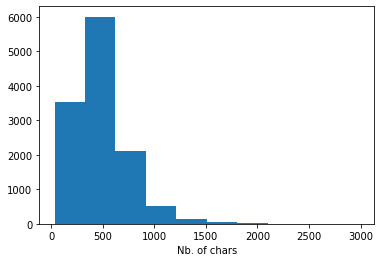

In [5]:
plt.hist(directions_lengths)
plt.xlabel("Nb. of chars")
plt.show()

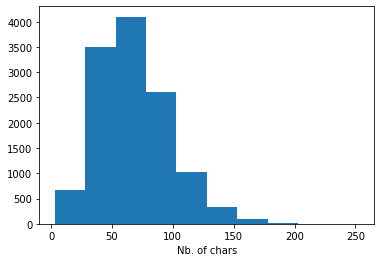

In [6]:
plt.hist(ingredients_lengths)
plt.xlabel("Nb. of chars")
plt.show()

In [7]:
special_chrs = [chr for chr in set(''.join(recipes_df_small["Directions"])) if not chr.isalnum()]
special_chrs.extend([chr for chr in set(''.join(recipes_df_small["Ingredients"])) if not chr.isalnum()])
special_chrs = list(set(special_chrs))
print(special_chrs)

['.', '-', ':', '\x99', '#', '>', ',', '{', '<', '(', '"', "'", '®', ' ', '*', '?', '+', '%', '&', '!', ')', '/', '=', '}']


In [8]:
# for index, row in recipes_df_small.iterrows():
#   print(index)
#   _dirs = unicodedata.normalize('NFKD', row["Directions"]).encode('ascii', 'ignore').decode("utf-8")
#   _ingreds = unicodedata.normalize('NFKD', row["Ingredients"]).encode('ascii', 'ignore').decode("utf-8")
  
#   for sp_chr in special_chrs: 
#     _dirs = _dirs.replace(sp_chr, " ")
#     if sp_chr != ",":
#       _ingreds = _ingreds.replace(sp_chr, " ")
#   print(' '.join(_dirs.split()))
#   print(' '.join(_ingreds.split()))
#   break

# unicodedata.normalize('NFKD', recipes_df_small["Ingredients"][1]).encode('ascii', 'ignore').decode("utf-8").split(",")


def preprocess_dirs(text):
  _dirs = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode("utf-8")
  for sp_chr in special_chrs: 
    _dirs = _dirs.replace(sp_chr, " ")
  _dirs = re.sub('\d', '', _dirs)
  return ' '.join(_dirs.split())

def preprocess_ingred(text):
  _ingreds = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode("utf-8")
  for sp_chr in special_chrs: 
    if sp_chr != ",":
      _ingreds = _ingreds.replace(sp_chr, " ")
  _ingreds = re.sub('\d', '', _ingreds)
  return ' '.join(_ingreds.split())

recipes_df_small["lo_directions"] = recipes_df_small["Directions"].str.lower()
recipes_df_small["lo_ingredients"] = recipes_df_small["Ingredients"].str.lower()

recipes_df_small["norm_directions"] = recipes_df_small["lo_directions"].apply(preprocess_dirs)
recipes_df_small["norm_ingredients"] = recipes_df_small["lo_ingredients"].apply(preprocess_ingred)

recipes_df_small.head(3)

,Directions,Ingredients,lo_directions,lo_ingredients,norm_directions,norm_ingredients
0,"Dissolve yeast in warm water.**Stir in sugar, ...","yeast,water,white sugar,salt,egg,butter,flour,...","dissolve yeast in warm water.**stir in sugar, ...","yeast,water,white sugar,salt,egg,butter,flour,...",dissolve yeast in warm water stir in sugar sal...,"yeast,water,white sugar,salt,egg,butter,flour,..."
1,'Preheat oven to 350 degrees F (175 degrees C)...,"flour,salt,baking powder,poppy,butter,vegetabl...",'preheat oven to 350 degrees f (175 degrees c)...,"flour,salt,baking powder,poppy,butter,vegetabl...",preheat oven to degrees f degrees c grease bot...,"flour,salt,baking powder,poppy,butter,vegetabl..."
2,Preheat oven to 350 degrees F (175 degrees C)....,"flour,egg,white sugar,vegetable oil,applesauce...",preheat oven to 350 degrees f (175 degrees c)....,"flour,egg,white sugar,vegetable oil,applesauce...",preheat oven to degrees f degrees c grease and...,"flour,egg,white sugar,vegetable oil,applesauce..."


In [9]:
words_lo_dirs = set()
words_norm_dirs = set()
sentence_sz_lo_dirs = []
sentence_sz_norm_dirs = []
for _, row in recipes_df_small.iterrows():
  words_lo_dirs.update(row["lo_directions"].split())
  sentence_sz_lo_dirs.append(len(row["lo_directions"].split()))
  words_norm_dirs.update(row['norm_directions'].split())
  sentence_sz_norm_dirs.append(len(row["norm_directions"].split()))
print("lower directions: nb of distinct words :", len(words_lo_dirs),
      "max sentece size:", max(sentence_sz_lo_dirs))
print("nb of distinct words norma:", len(words_norm_dirs),
      "max sentece size:", max(sentence_sz_norm_dirs))




lower directions: nb of distinct words : 20905 max sentece size: 546
nb of distinct words norma: 5366 max sentece size: 524


### Params

In [41]:
params = {
    'dim' : 300,            # dimension of embeddings
    'maximum_steps' : 1000, # number of training steps        
    'lstm_size' : 150,      # dimension of LSTM
    'batch_size' : 25,      # batch size
    'max_words' : 20100, #6000/ 10000,    # maximum number of words to embed
    'padding_size' : 600,    #20 maximum sentence size
    'num_classes' : 3,     # number of unique classes
    'save_dir' : 'drive/MyDrive/recipes/saved_model_tf/' # directory to save hash tables, model weights, etc.
}

### Data split

In [42]:
colname1, colname2 = 'lo_directions', 'lo_ingredients'
X = recipes_df_small[colname1].copy()
y = recipes_df_small[colname2].copy()

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8, random_state= 11 )
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=11)

print("Train: ", X_train.shape, y_train.shape)
print("Val:", X_valid.shape, y_valid.shape)
print("Test:", X_test.shape, y_test.shape)

Train:  (9876,) (9876,)
Val: (1234,) (1234,)
Test: (1235,) (1235,)


In [43]:
# pd.concat([X_train, y_train], axis=1)

### Helpers & tokenizer

In [44]:
def save_obj(directory, obj, name):
    '''Helper function using pickle to save and load objects'''
    with open(directory + name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(directory, name):
    '''Helper function using pickle to save and load objects'''
    with open(directory + name + ".pkl", "rb") as f:
        return pickle.load(f)
    
def load_data(df, colname1, colname2):
    '''Helper function to load and transform inputs and labels
    included as a separate function due to NER-specific evaluation needs:
        tensorflow does not have multi-class precision/accuracy as a metric
        so data_y is needed to manually calculate evaluations'''
    data_x, data_y = [], []
    for index, line in df.iterrows():
        data_x.append(line[colname1])
        data_y.append(line[colname2]) 
    return data_x, data_y

In [45]:
def make_tokenizer(df, colname1, colname2, params = params):
    ''' In order for one hot encoding of words and labels to work, 
    every word and label has to be seen at least once to make a hashing table.
    This function outputs hash tables for the words and the labels
    that can be used to one-hot-encode them in the generator
    '''
    # Load parameters and data
    max_words = params['max_words']
    padding_size = params['padding_size']
    save_dir = params['save_dir']
    data_x, data_y = load_data(df, colname1, colname2)
            
    # Use the Keras tokenizer API to generate hashing table for data_x
    tokenizer = Tokenizer(num_words = max_words)
    
    tokenizer.fit_on_texts(data_x)
    word_index = tokenizer.word_index
    
    # Flatten data_y and create hashing table using set logic
    # data_y_flattened = [item for sublist in data_y for item in sublist]
    # data_x_flattened = [item for sublist in data_x for item in sublist]
    
    # labels_index = dict([(y, x + 1) for x, y in enumerate(sorted(set(data_y_flattened)))])
    labels_index = {'INGREDIENT': 1, 'O': 2}
    labels_lookup = {1:'INGREDIENT', 2:'O'}
    # labels = []
    # for item in data_y:
    #     labels.append([labels_index.get(i) for i in item])
    # labels_lookup = {v : k for k, v in labels_index.items()} # reverse dictionary for lookup
    # save hash tables to disk for model serving
    for item, name in zip([word_index, labels_index, labels_lookup],
                          ["word_index", "labels_index", "labels_lookup"]):
        save_obj(save_dir, item, name)
    return word_index, labels_index, labels_lookup

In [46]:
word_index, labels_index, labels_lookup = \
  make_tokenizer(recipes_df_small[[colname1, colname2]],
                 colname1, colname2)

In [47]:
print(labels_lookup)
print(labels_index)

{1: 'INGREDIENT', 2: 'O'}
{'INGREDIENT': 1, 'O': 2}


### Helpers & train

In [48]:
def generate_batches(df, colname1, colname2, params = params, train = True):
    ''' Generate minibatch with dimensions:
    batch_x : (batch_size, max_len)
    lengths : (batch_size,)
    batch_y : (batch_size, num_classes)
    
    file : path to .txt containing training data in BIO format
    '''
    
    batch_size = params['batch_size']
    max_len = params['padding_size']
    save_dir = params['save_dir']
    
    # load hash tables for tokenization
    for item, name in zip([word_index, labels_index, labels_lookup],
                          ["word_index", "labels_index", "labels_lookup"]):
        item = load_obj(save_dir, name)
    
    while True:
      batch_x, lengths, batch_y = [], [], []
      words, labels = [], []
      for index, line in df.iterrows():
        _descr = line[colname1].split()
        _ingred = re.split(',\s*|\s+', line[colname2])
        # _ingred = line[colname2].split(",")
        _labels = [ "INGREDIENT" if word in _ingred else "O" for word in _descr]
        
        words = [word_index.get(x) if x in word_index.keys() else 0 for x in _descr]
        labels = [labels_index.get(y) for y in _labels]

        batch_x.append(words)
        batch_y.append(labels)
        lengths.append(min(len(words), max_len))
        words, labels = [], []

        if len(batch_x) == batch_size:
          batch_x = pad_sequences(batch_x, maxlen = max_len, value = 0, padding = "post")
          batch_y = pad_sequences(batch_y, maxlen = max_len, value = 0, padding = "post")
          yield (batch_x, lengths), batch_y 
          batch_x, lengths, batch_y = [], [], []
      if train == False:
        break

In [78]:
# For model training, we need an input function that will feed a tf.Dataset
def input_fn(df, colname1, colname2, params = None, train = True):
    params = params if params is not None else {}
    shapes = (([None, None], [None]), [None, None]) # batch_x, lengths, batch_y shapes
    types = ((tf.int32, tf.int32), tf.int32)        # batch_x, lengths, batch_y data types
    
    generator = partial(generate_batches, df, colname1, colname2, train = train)
    dataset = tf.data.Dataset.from_generator(generator, types, shapes)
    return dataset

# For model serving, we need a serving function that will feed tf.placeholders
def serving_input_fn():
    words = tf.compat.v1.placeholder(dtype=tf.int32, shape=[None, None], name='words')
    length = tf.compat.v1.placeholder(dtype=tf.int32, shape=[None], name='length')
    receiver_tensors = {'words': words, 'length': length}
    features = {'words': words, 'length': length}
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [74]:
def model_fn(features, labels, mode, params = params):
    # import the data and unpack the features
    # serving input_fn returns a dict, convert to multivalue obj
    if isinstance(features, dict):
        features = features['words'], features['length']
    
    words, length = features
    
    # Embedding
    embedding = tf.Variable(tf.random.normal([params['max_words'], params['dim']]))
    embedding_lookup_for_x = tf.nn.embedding_lookup(embedding, words)
    
    # LSTM
    lstm_cell_fw = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(params['lstm_size'], state_is_tuple = True)
    lstm_cell_bw = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(params['lstm_size'], state_is_tuple = True)
    states, final_state = tf.compat.v1.nn.bidirectional_dynamic_rnn(
                                        cell_fw = lstm_cell_fw, 
                                        cell_bw = lstm_cell_bw,
                                        inputs = embedding_lookup_for_x, 
                                        dtype = tf.float32,
                                        time_major = False,
                                        sequence_length = length)
    lstm_out = tf.concat([states[0], states[1]], axis = 2)
        
    # Conditional random fields
    logits = tf.compat.v1.layers.dense(lstm_out, params['num_classes'])
    crf_params = tf.compat.v1.get_variable("crf", [params['num_classes'], params['num_classes']],
                                 dtype=tf.float32)
    pred_ids, _ = tfa.text.crf_decode(logits, crf_params, length)
    training = (mode == tf.estimator.ModeKeys.TRAIN)
    
    # Prediction
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = { 
            'pred_ids': pred_ids,
            'tags': words,
            'length' : length,
        }
        export_outputs = {
          'prediction': tf.estimator.export.PredictOutput(predictions)
      }
        
        return tf.estimator.EstimatorSpec(mode, predictions=predictions,
                                          export_outputs=export_outputs)
    
    # Loss functions and optimizers
    log_likelihood, _ = tfa.text.crf_log_likelihood(
        logits, labels, length, crf_params)
    
    loss = tf.reduce_mean(-log_likelihood)
    train_op = tf.compat.v1.train.AdamOptimizer().minimize(
        loss, global_step = tf.compat.v1.train.get_or_create_global_step())
        
    # Training
    if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode = mode,
                                           loss = loss,
                                           train_op = train_op)

In [75]:
# Spin up the estimator
config = tf.estimator.RunConfig()
estimator = tf.estimator.Estimator(model_fn, 'drive/MyDrive/recipes/model', config, params)

# Create train spec
df_train = pd.concat([X_train, y_train], axis=1)
train_input_fn = partial(input_fn, df_train, colname1, colname2, params = params)
train_spec = tf.estimator.TrainSpec(train_input_fn)

# Create evaluation spec
df_eval =  pd.concat([X_valid, y_valid], axis=1)
eval_input_fn = partial(input_fn, df_eval, colname1, colname2, params = params, train = False)
eval_spec = tf.estimator.EvalSpec(eval_input_fn)

INFO:tensorflow:Using config: {'_model_dir': 'drive/MyDrive/recipes/model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [76]:
ts = time.time()
estimator.train(input_fn = train_input_fn, max_steps = 1000)
te = time.time()
print("Completed in {} seconds".format(int(te - ts)))
# estimator.export_savedmodel('drive/MyDrive/recipes/saved_model_tf/', serving_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into drive/MyDrive/recipes/model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 48.706978, step = 0
INFO:tensorflow:global_step/sec: 0.687207
INFO:tensorflow:loss = 3.705659, step = 100 (145.520 sec)
INFO:tensorflow:global_step/sec: 0.740285
INFO:tensorflow:loss = 3.7655323, step = 200 (135.086 sec)
INFO:tensorflow:global_step/sec: 0.760379
INFO:tensorflow:loss = 3.2581573, step = 300 (131.511 sec)
INFO:tensorflow:global_step/sec: 0.737483
INFO:tensorflow:loss = 5.1781445, step = 400 (135.601 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 437...
INFO:

AttributeError: ignored

In [79]:
estimator.export_saved_model('drive/MyDrive/recipes/saved_model_tf/', serving_input_fn)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['prediction', 'serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from drive/MyDrive/recipes/model/model.ckpt-1000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: drive/MyDrive/recipes/saved_model_tf/temp-1630437237/saved_model.pb


b'drive/MyDrive/recipes/saved_model_tf/1630437237'